D:\Publish Paper\ML in Cyber_ash\Plant_disease_detector\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 5/5 [01:48<00:00, 21.73s/it]


Epoch 1/10, Train Loss: 1.4189281702041625, Val Loss: 0.6726199388504028, Val Accuracy: 1.0


100%|██████████| 5/5 [01:15<00:00, 15.12s/it]


Epoch 2/10, Train Loss: 0.5350518941879272, Val Loss: 0.39245927333831787, Val Accuracy: 1.0


100%|██████████| 5/5 [01:15<00:00, 15.13s/it]


Epoch 3/10, Train Loss: 0.3556469678878784, Val Loss: 0.30006659030914307, Val Accuracy: 1.0


100%|██████████| 5/5 [01:15<00:00, 15.02s/it]


Epoch 4/10, Train Loss: 0.28581897616386415, Val Loss: 0.25292718410491943, Val Accuracy: 1.0


100%|██████████| 5/5 [01:15<00:00, 15.16s/it]


Epoch 5/10, Train Loss: 0.2461212158203125, Val Loss: 0.22139009833335876, Val Accuracy: 1.0


100%|██████████| 5/5 [01:16<00:00, 15.29s/it]


Epoch 6/10, Train Loss: 0.2181407928466797, Val Loss: 0.19747020304203033, Val Accuracy: 1.0


100%|██████████| 5/5 [01:15<00:00, 15.10s/it]


Epoch 7/10, Train Loss: 0.1953759104013443, Val Loss: 0.17765578627586365, Val Accuracy: 1.0


100%|██████████| 5/5 [01:23<00:00, 16.69s/it]


Epoch 8/10, Train Loss: 0.17627124190330506, Val Loss: 0.16090063750743866, Val Accuracy: 1.0


100%|██████████| 5/5 [01:26<00:00, 17.34s/it]


Epoch 9/10, Train Loss: 0.16406964659690856, Val Loss: 0.1463645100593567, Val Accuracy: 1.0


100%|██████████| 5/5 [01:26<00:00, 17.24s/it]


Epoch 10/10, Train Loss: 0.14915416836738588, Val Loss: 0.13367147743701935, Val Accuracy: 1.0
Validation Loss: 0.13367147743701935, Validation Accuracy: 1.0


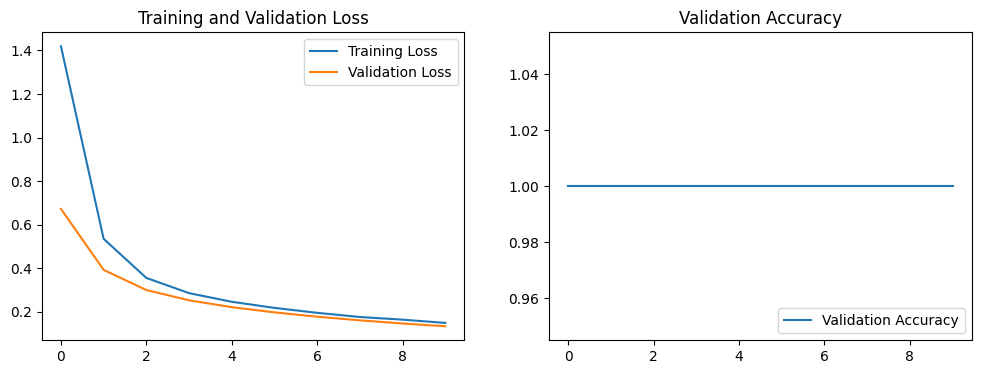

D:\Publish Paper\ML in Cyber_ash\Plant_disease_detector\.venv\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (10).

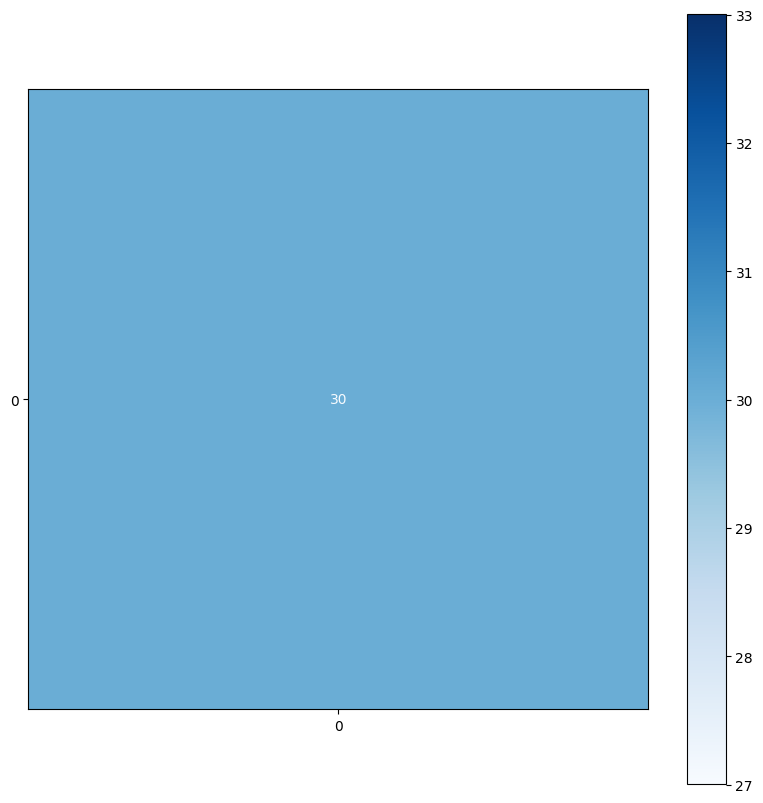

In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# Ensure we use a GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom dataset class for loading tomato leaf images and labels
class TomatoLeafDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Function to load data from the dataset directory
def load_data(data_dir):
    classes = os.listdir(data_dir)
    classes.sort()  # Ensure the classes are sorted
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

    image_paths = []
    labels = []

    for cls_name in classes:
        cls_dir = os.path.join(data_dir, cls_name)
        for root, _, files in os.walk(cls_dir):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(root, file))
                    labels.append(class_to_idx[cls_name])

    return image_paths, labels, class_to_idx

# Define paths to training and validation datasets
data_dir = 'D:\\Publish Paper\\Dataset plant\\PlantDiseasesDataset\\train'
val_data_dir = 'D:\\Publish Paper\\Dataset plant\\PlantDiseasesDataset\\valid'

# Load training and validation data
train_image_paths, train_labels, class_to_idx = load_data(data_dir)
val_image_paths, val_labels, _ = load_data(val_data_dir)
class_names = list(class_to_idx.keys())

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and dataloaders
train_dataset = TomatoLeafDataset(train_image_paths, train_labels, transform=transform)
val_dataset = TomatoLeafDataset(val_image_paths, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
num_classes = len(class_to_idx)

# Load the pre-trained ViT model and specify the number of labels
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_classes)
model = model.to(device)

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()

# Training function
def train(model, train_loader, val_loader, epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))
        
        val_loss, val_accuracy, _, _ = evaluate(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')

    return train_losses, val_losses, val_accuracies

# Evaluation function
def evaluate(model, val_loader):
    model.eval()
    val_loss = 0
    correct = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = correct / len(val_loader.dataset)
    
    return val_loss, val_accuracy, all_preds, all_labels

# Train the model
epochs = 10
train_losses, val_losses, val_accuracies = train(model, train_loader, val_loader, epochs)

# Evaluate the model on the validation set and get predictions
val_loss, val_accuracy, all_preds, all_labels = evaluate(model, val_loader)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Plot training & validation loss and accuracy
epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.show()

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

Step 2: Saving the model

In [6]:
model.save_pretrained('D:\\Publish Paper\\ML in Cyber_ash\\Plant_disease_detector')

Step 2: Data Preparation

In [7]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification

# Ensure we use a GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the trained ViT model
model = ViTForImageClassification.from_pretrained('D:\\Publish Paper\\ML in Cyber_ash\\Plant_disease_detector', num_labels=num_classes)
model = model.to(device)

# Example class names (should match the class names used in your training)
class_names = [
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

# Prediction function
def predict_disease(model, image_path, transform, class_names, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image).logits
        _, preds = torch.max(outputs, 1)
    
    return class_names[preds.item()]

# Test function
def test_model_on_image(model, image_path, transform, class_names, device):
    prediction = predict_disease(model, image_path, transform, class_names, device)
    print(f'Predicted disease: {prediction}')

# Example usage
image_path = 'D:\\Publish Paper\\Dataset plant\\PlantDiseasesDataset\\train\\Tomato___Leaf_Mold\\1fa78650-4f81-4c8f-9190-91f1057d1158___Crnl_L.Mold 9083.JPG'  # Replace with your test image path
test_model_on_image(model, image_path, transform, class_names, device)


Predicted disease: Tomato___healthy
